In [12]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime as dt
import glob

from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from scipy.special import rel_entr
import scipy.stats as SciStat
import pickle
import seaborn as sns

In [13]:
from google.colab import output
output.enable_custom_widget_manager()
!pip install ipympl ucimlrepo

In [14]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features


# metadata
print(air_quality.metadata)

# variable information
print(X)


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

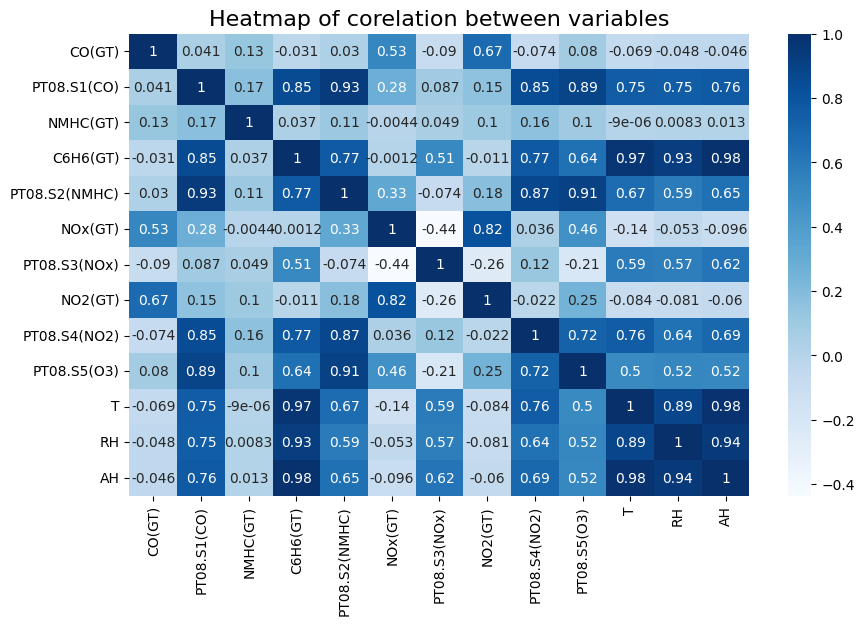

In [15]:
plt.figure(figsize=(10, 6))
# load the Auto dataset
sns.heatmap(X.iloc[:,2:].corr(),annot=True,cmap='Blues')
plt.title('Heatmap of corelation between variables',fontsize=16)
plt.show()



<ipython-input-16-15f9a637c052>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


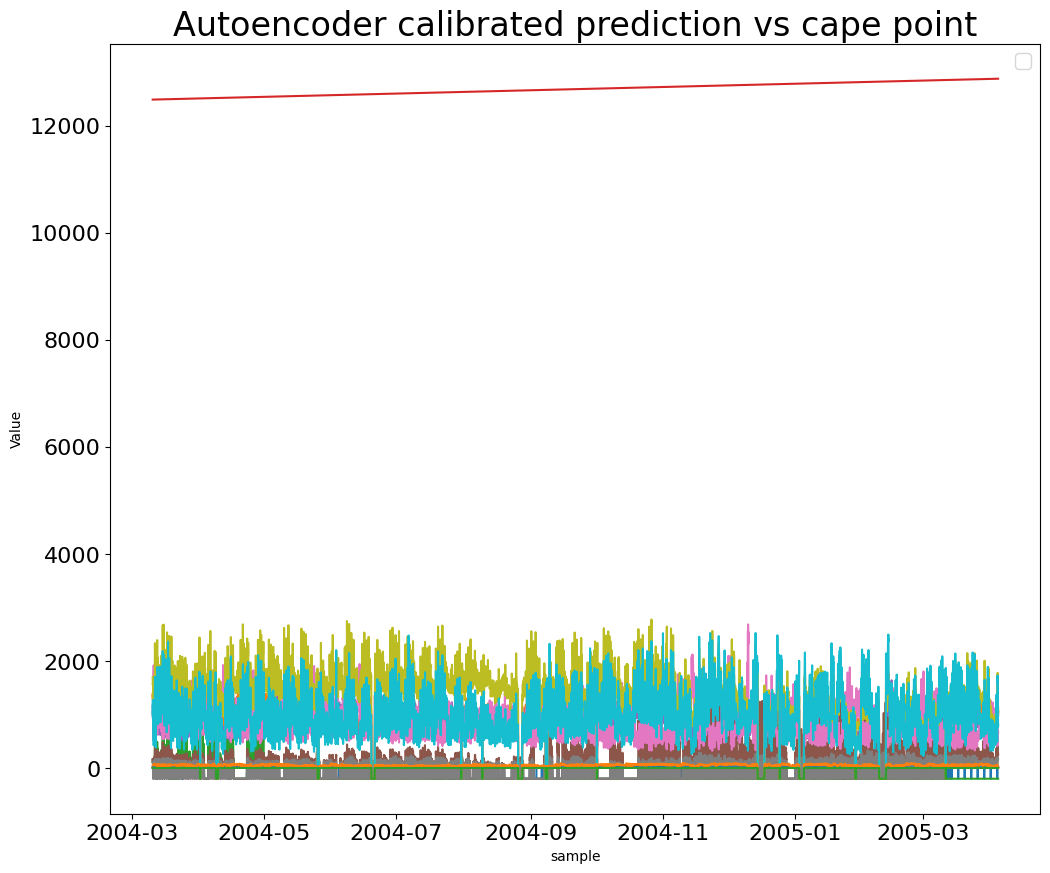

In [16]:
#%matplotlib widget

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
plt.rcParams.update({'font.size': 16})

X['DateTime'] = pd.to_datetime(X.iloc[:, 0] + ' ' + X.iloc[:, 1])

plt.title('Autoencoder calibrated prediction vs cape point',fontsize=24)
plt.plot(X['DateTime'], X.iloc[:, 2:])



plt.xlabel('sample',fontsize=10)
plt.ylabel('Value',fontsize=10)
plt.legend(fontsize=14)

<Figure size 640x480 with 0 Axes>

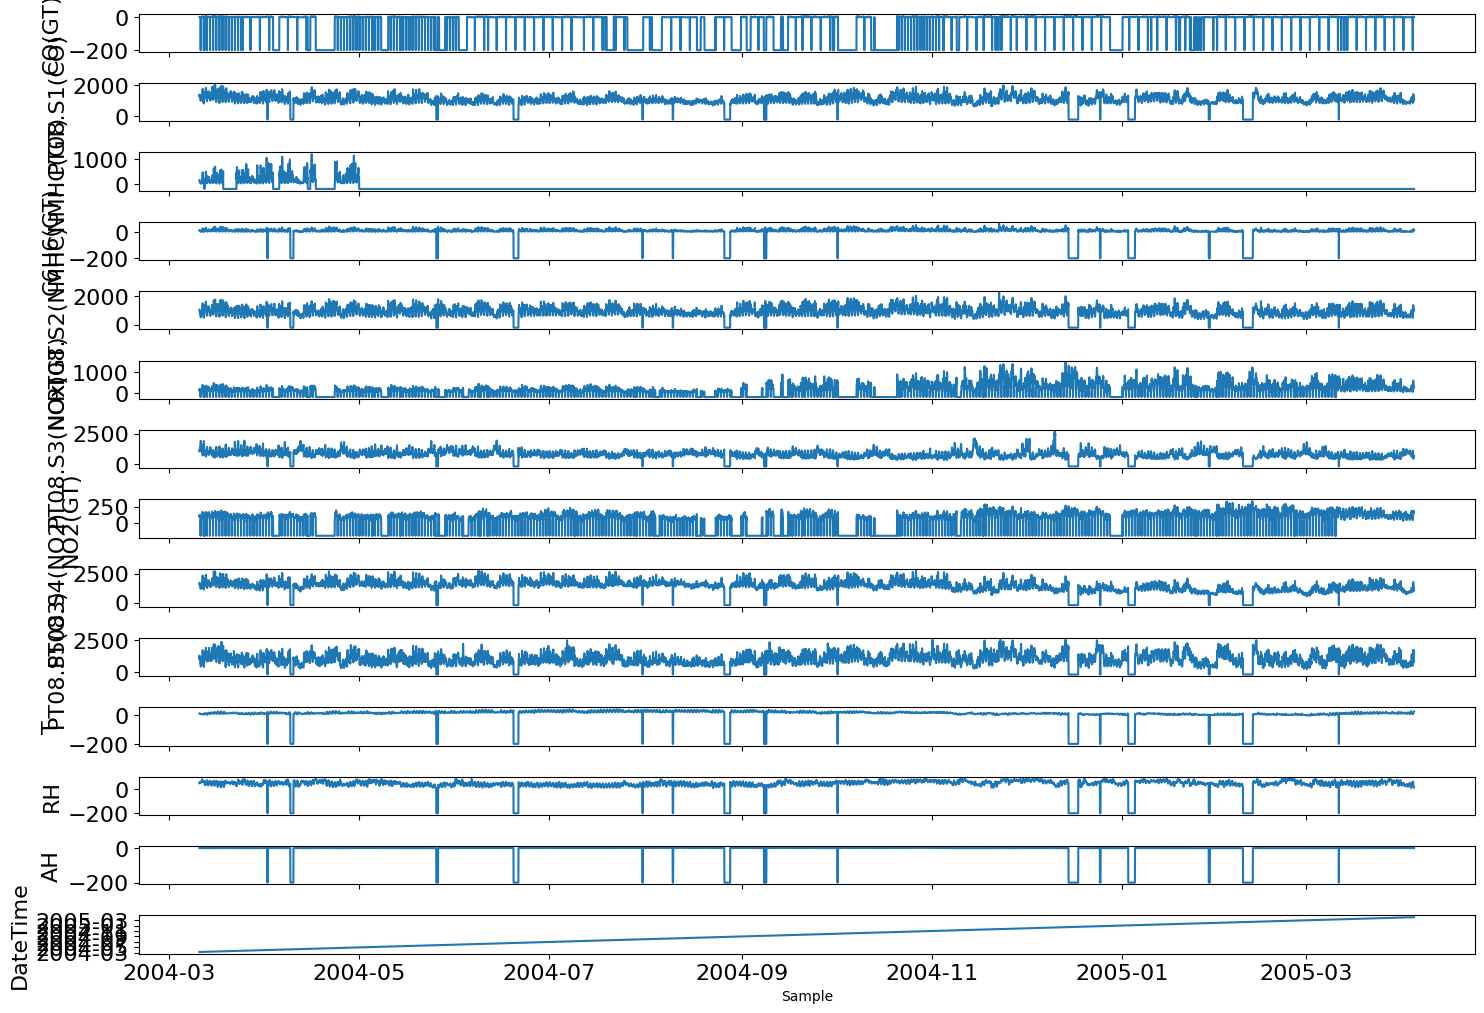

In [53]:
# Get the number of columns to plot (excluding DateTime)
num_cols = X.shape[1]
plt.suptitle('Each sensor in seperate plot', fontsize=24)
# Create subplots
fig, axes = plt.subplots(num_cols-2, 1, sharex=True, figsize=(14, 10))

# Adjust subplot spacing
fig.tight_layout(pad=0.5)

plt.rcParams.update({'font.size': 16})  # Update font size for all plots

# Plot each column in a separate subplot
for i in range(num_cols-2):
    ax = axes[i]  # Get the current subplot axes
    ax.plot(X['DateTime'], X.iloc[:, i + 2])  # Plot data
    ax.set_ylabel(X.columns[i + 2])  # Set y-axis label to column name


plt.xlabel('Sample', fontsize=10)

plt.show()

In [18]:
#Clean Dataset
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    #df.dropna(inplace=True)
    indices_to_keep = ~df.apply(lambda row: any(x == -200 for x in row), axis=1)
    #indices_to_keep = ~df.isin({ 'CO2_PPM' : [np.nan, np.inf, -np.inf, '#']}).any(axis=1)
    return df[indices_to_keep]



In [19]:
co_combined = clean_dataset(X.loc[:, ['PT08.S1(CO)', 'T', 'RH', 'AH', 'CO(GT)']])
nmhc_combined = clean_dataset(X.loc[:, ['PT08.S2(NMHC)', 'T', 'RH', 'AH', 'NMHC(GT)']])
nox_combined = clean_dataset(X.loc[:, ['PT08.S3(NOx)', 'T', 'RH', 'AH', 'NOx(GT)']])
no2_combined = clean_dataset(X.loc[:, ['PT08.S4(NO2)', 'T', 'RH', 'AH', 'NO2(GT)']])
print(co_combined)

      PT08.S1(CO)     T    RH      AH  CO(GT)
0            1360  13.6  48.9  0.7578     2.6
1            1292  13.3  47.7  0.7255     2.0
2            1402  11.9  54.0  0.7502     2.2
3            1376  11.0  60.0  0.7867     2.2
4            1272  11.2  59.6  0.7888     1.6
...           ...   ...   ...     ...     ...
9352         1314  21.9  29.3  0.7568     3.1
9353         1163  24.3  23.7  0.7119     2.4
9354         1142  26.9  18.3  0.6406     2.4
9355         1003  28.3  13.5  0.5139     2.1
9356         1071  28.5  13.1  0.5028     2.2

[7344 rows x 5 columns]


In [20]:
X_clean = clean_dataset(X)

co_features = co_combined.loc[:, ['PT08.S1(CO)', 'T', 'RH', 'AH']]
#print(co_features)
co_labels = co_combined.loc[:, ['CO(GT)']]
#print(co_labels)
nmhc_features = nmhc_combined.loc[:, ['PT08.S2(NMHC)', 'T', 'RH', 'AH']]
#print(nmhc_features)
nmhc_labels = nmhc_combined.loc[:, ['NMHC(GT)']]
#print(nmhc_labels)
nox_features = nox_combined.loc[:, ['PT08.S3(NOx)', 'T', 'RH', 'AH']]
#print(nox_features)
nox_labels = nox_combined.loc[:, ['NOx(GT)']]
#print(nox_labels)
no2_features = no2_combined.loc[:, ['PT08.S4(NO2)', 'T', 'RH', 'AH']]
#print(no2_features)
no2_labels = no2_combined.loc[:, ['NO2(GT)']]


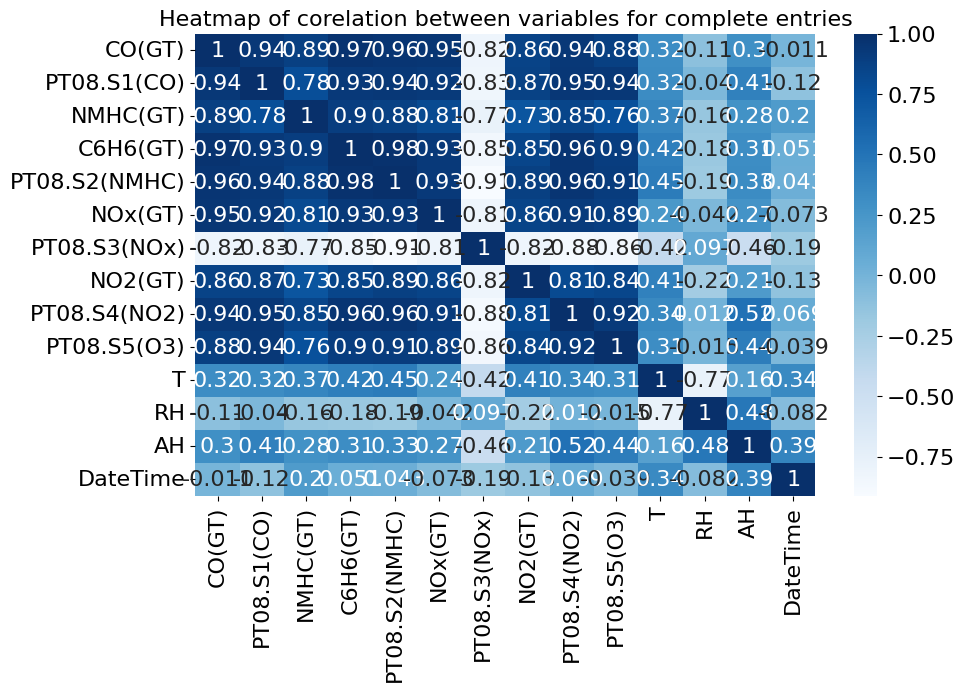

In [21]:
plt.figure(figsize=(10, 6))
# load the Auto dataset
sns.heatmap(X_clean.iloc[:,2:].corr(),annot=True,cmap='Blues')
plt.title('Heatmap of corelation between variables for complete entries',fontsize=16)
plt.show()



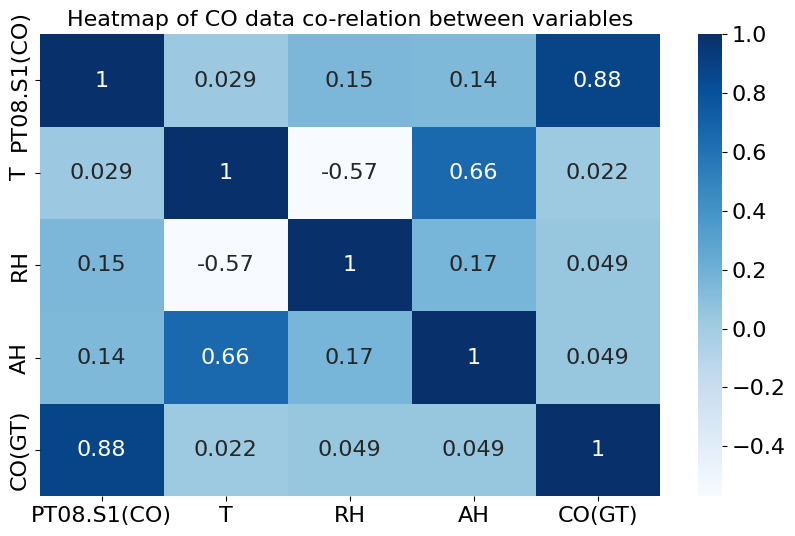

In [22]:
plt.figure(figsize=(10, 6))
# load the Auto dataset
sns.heatmap(co_combined.corr(),annot=True,cmap='Blues')
plt.title('Heatmap of CO data co-relation between variables',fontsize=16)
plt.show()



In [23]:

feature = co_features.astype(float).to_numpy()


label = co_labels.astype(float).to_numpy()



print(feature)
print(label)

[[1.360e+03 1.360e+01 4.890e+01 7.578e-01]
 [1.292e+03 1.330e+01 4.770e+01 7.255e-01]
 [1.402e+03 1.190e+01 5.400e+01 7.502e-01]
 ...
 [1.142e+03 2.690e+01 1.830e+01 6.406e-01]
 [1.003e+03 2.830e+01 1.350e+01 5.139e-01]
 [1.071e+03 2.850e+01 1.310e+01 5.028e-01]]
[[2.6]
 [2. ]
 [2.2]
 ...
 [2.4]
 [2.1]
 [2.2]]


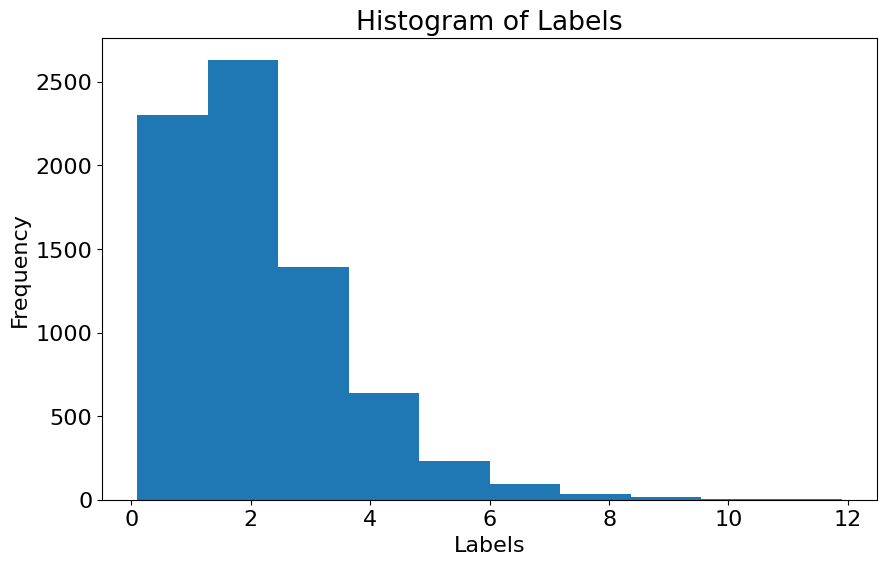

In [24]:
# prompt: plot a histogram of labels

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(label, bins=10)  # Adjust the number of bins as needed
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Histogram of Labels")
plt.show()

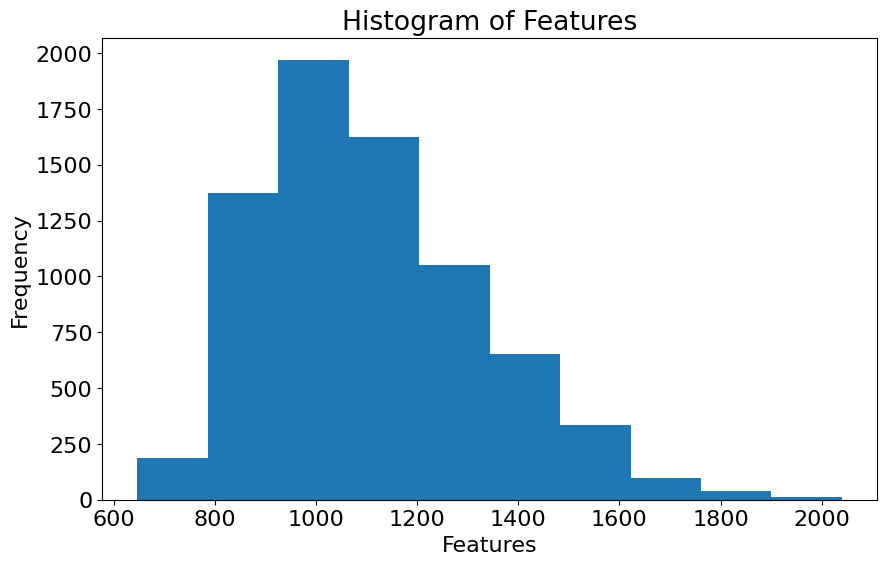

1292.0


In [25]:
# prompt: plot a histogram of features
plt.figure(figsize=(10, 6))
plt.hist(feature[:,0], bins=10)  # Adjust the number of bins as needed
plt.xlabel("Features")
plt.ylabel("Frequency")
plt.title("Histogram of Features")
plt.show()
print(feature[1,0])

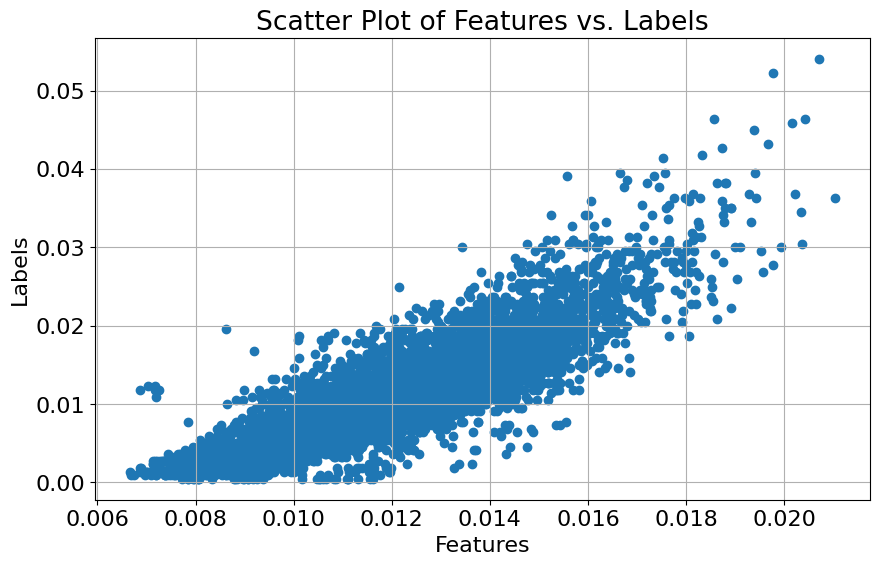

In [26]:
# prompt:  plot features and label
# norm_lab = label[:,0]/np.linalg.norm(label).reshape(-1)
# print(norm_lab)
# norm_feat = feature[:,0]/np.linalg.norm(feature[:,0])
# print(norm_feat)
# abs_error = norm_lab - norm_feat
# print(abs_error)
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
#plt.plot(feature[:,0]/np.linalg.norm(feature[:,0]))
plt.scatter(feature[:,0]/np.linalg.norm(feature[:,0]),label[:,0]/np.linalg.norm(label))
#plt.plot(label[:,0]/np.linalg.norm(label), alpha=0.5)  # alpha controls transparency

plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Scatter Plot of Features vs. Labels")
plt.grid(True)
plt.show()

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import mse
import keras.backend as K

## Test of VAE for calibration using Environmental Factors

In [28]:

combined = co_combined.astype(float).to_numpy()

def column_wize_norm_minmax(input): #minmax scales each column of the array
  bias = input.min()
  scale = input.max() - bias
  out_df = (input-bias)/(scale)
  return [bias, scale, out_df]



# Normalize the matrix

bias_feature, scale_feature, normalized_feature = column_wize_norm_minmax(co_features.astype(float).to_numpy())


bias_combined, scale_combined, normalized_combined = column_wize_norm_minmax(co_combined)

print(normalized_feature)
print(normalized_combined)


[[0.66697684 0.00759097 0.02487879 0.00130163]
 [0.63367452 0.00744405 0.0242911  0.00128581]
 [0.68754591 0.00675841 0.02737646 0.00129791]
 ...
 [0.56021353 0.01410451 0.00989275 0.00124423]
 [0.49213967 0.01479015 0.007542   0.00118218]
 [0.52544199 0.01488809 0.0073461  0.00117675]]
      PT08.S1(CO)         T        RH        AH    CO(GT)
0        0.511845  0.333333  0.499371  0.287139  0.211864
1        0.463029  0.326882  0.484277  0.270955  0.161017
2        0.541996  0.296774  0.563522  0.283331  0.177966
3        0.523331  0.277419  0.638994  0.301618  0.177966
4        0.448672  0.281720  0.633962  0.302670  0.127119
...           ...       ...       ...       ...       ...
9352     0.478823  0.511828  0.252830  0.286638  0.254237
9353     0.370424  0.563441  0.182390  0.264141  0.194915
9354     0.355348  0.619355  0.114465  0.228418  0.194915
9355     0.255564  0.649462  0.054088  0.164938  0.169492
9356     0.304379  0.653763  0.049057  0.159377  0.177966

[7344 rows x 5 

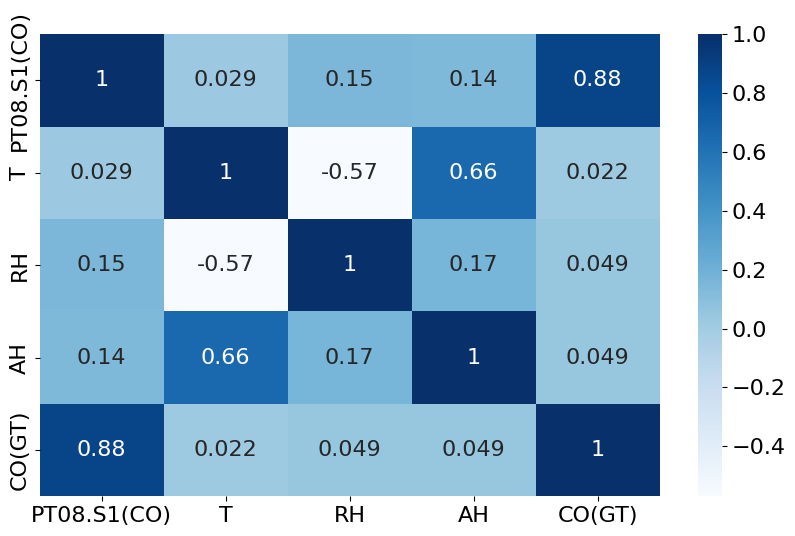

In [29]:


plt.figure(figsize=(10, 6))
# load the Auto dataset


# calculate the correlation matrix on the numeric columns
sns.heatmap(normalized_combined.corr(),annot=True,cmap='Blues')

plt.show()



In [30]:
import tensorflow_probability as tfp

In [31]:
input_dim = 4
inter_dim = 4
latent_dim = 2
# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(inter_dim, activation='sigmoid')(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.)
    return z_mean + tf.exp(z_log_var / 2) * epsilon

# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = tfp.random.rayleigh(shape=tf.shape(z_mean), scale=1)
#     return z_mean + tf.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(inter_dim, activation='sigmoid')(latent_inputs)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE model (combining encoder and decoder)
vae_outputs = decoder(encoder(encoder_inputs)[2])

vae_combined_outputs = tf.keras.layers.Concatenate(axis=1)([z_mean, z_log_var, z, vae_outputs])

vae = Model(encoder_inputs, vae_combined_outputs, name='vae')

# Loss function (reconstruction loss + KL divergence)
def loss_fn(vae_in, vae_combined):
  reconstruction_loss = tf.keras.losses.mse(vae_in[:,:-1], vae_combined[:,-4:])
  z_log_var = vae_combined[:,1]
  z_mean = vae_combined[:,0]

  kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
  kl_loss = tf.reduce_mean(kl_loss)
  kl_loss *= -0.5

  calibration_loss = tf.keras.losses.mse(vae_in[:,-1], vae_combined[:,2])

  vae_loss = tf.reduce_mean(1*reconstruction_loss + 1*kl_loss + 1*calibration_loss)
  return vae_loss

# Training
vae.compile(optimizer='adam' ,loss=loss_fn)

In [32]:
vae.fit(normalized_feature, normalized_combined, epochs=600, batch_size=16, shuffle=True)

Epoch 1/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2524
Epoch 2/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0489
Epoch 3/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0481
Epoch 4/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0476
Epoch 5/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0471
Epoch 6/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0461
Epoch 7/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0451
Epoch 8/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0441
Epoch 9/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0435
Epoch 10/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0424
Epoch 11/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0422
Epoch 12/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0422
Epoch 13/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0409
Epoch 14/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0409
Epoch 15/600
459/459 ━━━━━━━━━━━━━━━━━━━━ 1

In [35]:
pred_data_vae = vae.predict(normalized_feature) #includes internal layer outputs
reconstructed_data_vae = pred_data_vae[:,2] #select temp values output and resize normalised output data
print(pred_data_vae.shape)
print(len(pred_data_vae[:,2]))
print(len(normalized_combined.iloc[:,-1]))

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(7344, 10)
7344
7344


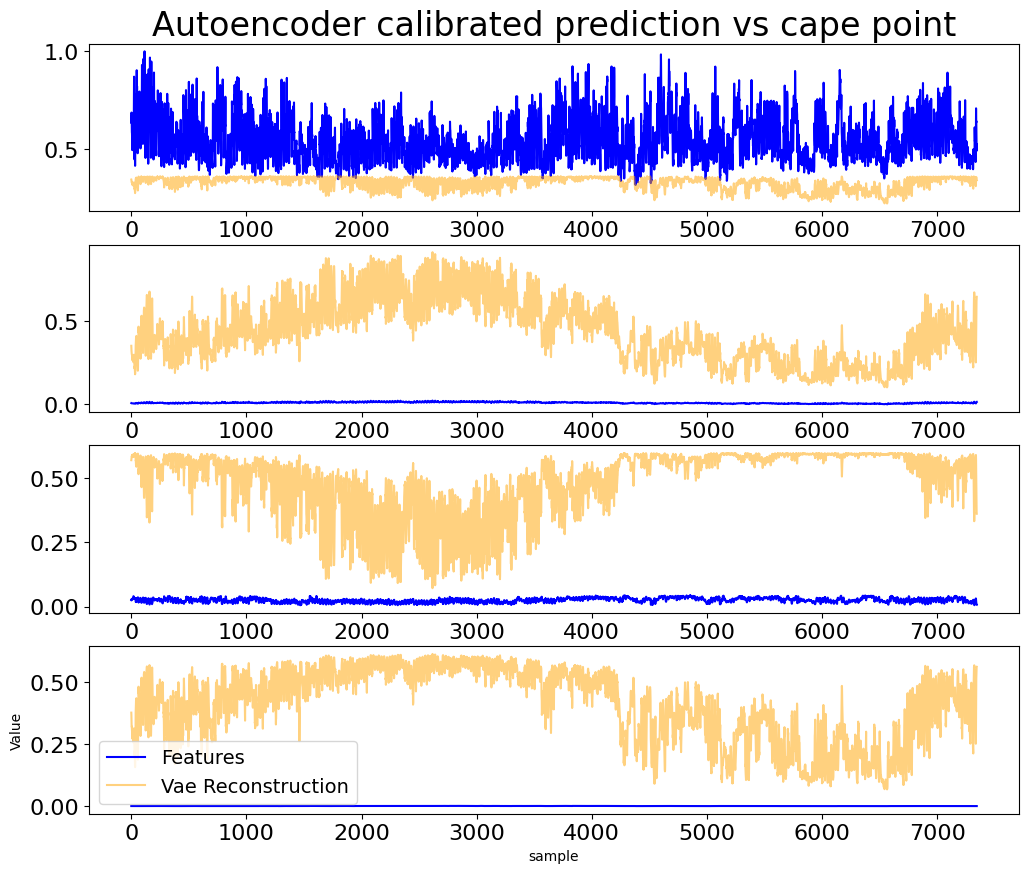

In [36]:
#%matplotlib widget

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
plt.rcParams.update({'font.size': 16})


plt.subplot(4,1,1)
plt.title('Autoencoder calibrated prediction vs cape point',fontsize=24)
plt.plot(normalized_feature[:,0].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae[:,-4]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)

plt.subplot(4,1,2)
plt.plot(normalized_feature[:,1].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae[:,-3]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)



plt.subplot(4,1,3)
plt.plot(normalized_feature[:,2].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae[:,-2]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)


plt.subplot(4,1,4)
plt.plot(normalized_feature[:,3].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae[:,-1]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)



plt.xlabel('sample',fontsize=10)
plt.ylabel('Value',fontsize=10)
plt.legend(fontsize=14)

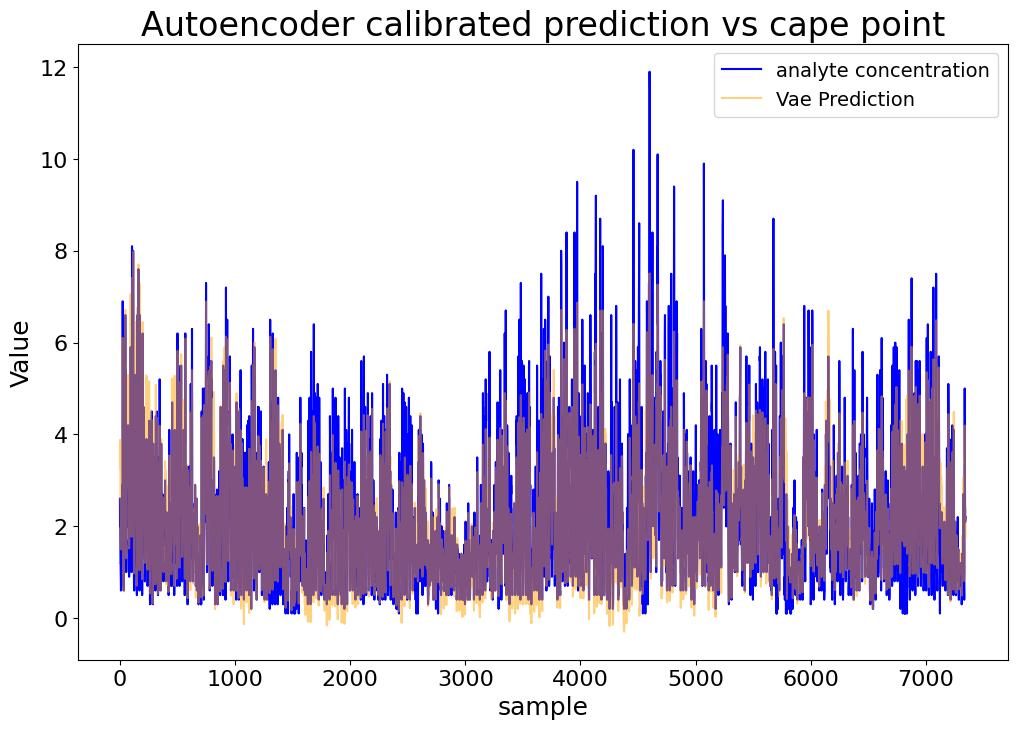

In [37]:
#%matplotlib widget

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.rcParams.update({'font.size': 16})

plt.plot((normalized_combined.iloc[:,-1].to_numpy()* scale_combined.iloc[-1]) + bias_combined.iloc[-1], color = 'blue',label='analyte concentration')
plt.plot((reconstructed_data_vae* scale_combined.iloc[-1]) + bias_combined.iloc[-1] , color = 'orange',label='Vae Prediction', alpha=0.5)


plt.title('Autoencoder calibrated prediction vs cape point',fontsize=24)
plt.xlabel('sample',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.legend(fontsize=14)

In [38]:

test_set = label.reshape(-1)

print(np.mean(test_set))
# Use the svr predict method on the test data
predictions = (reconstructed_data_vae* scale_combined[-1]) + bias_combined[-1]
print(predictions)
# Calculate the absolute errors
errors = abs(test_set - predictions)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'PPM.')
import sklearn.metrics
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_set)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

r_squared = sklearn.metrics.r2_score(test_set,predictions)

print('r2 value: ' , r_squared)

def compute_probs(data, n=10):
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def kl_divergence(p, q):
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)


es3, hist_predict = compute_probs(predictions, 10)
ecp, hist_test_labels = compute_probs(test_set, 10)

#Padding hist for no 0 value bins
hist_predict = hist_predict + 1
hist_test_labels = hist_test_labels + 1

p, t = SciStat.pearsonr(test_set, predictions)
print(p)


print('KL divergence: ' + str(kl_divergence(hist_test_labels, hist_predict)) )
print('JS divergence: ' + str(js_divergence(hist_test_labels, hist_predict )) )

2.1297113289760348
[3.659892  3.262128  3.8832362 ... 2.5136597 1.7366778 2.1333542]
Mean Absolute Error: 0.47 PPM.


<ipython-input-38-4405085eabc9>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = (reconstructed_data_vae* scale_combined[-1]) + bias_combined[-1]


Accuracy: 65.56 %.
r2 value:  0.7892064150465096
0.8883745861509731
KL divergence: 0.0437160332578241
JS divergence: 0.010709417026945589


## Test for VAE using Cross-Detection

In [39]:
cross_detect_combined = clean_dataset(X.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'CO(GT)', 'NMHC(GT)','NOx(GT)', 'NO2(GT)' ]])

cross_detect_features = cross_detect_combined.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)']]

CO_cross_detect_combined = cross_detect_combined.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'CO(GT)']]


NMHC_cross_detect_combined = cross_detect_combined.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'NMHC(GT)']]

NOx_cross_detect_combined = cross_detect_combined.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'NOx(GT)']]

NO2_cross_detect_combined = cross_detect_combined.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'NO2(GT)' ]]


bias_feature, scale_feature, normalized_feature = column_wize_norm_minmax(cross_detect_features.astype(float).to_numpy())


bias_combined, scale_combined, normalized_combined = column_wize_norm_minmax(CO_cross_detect_combined)



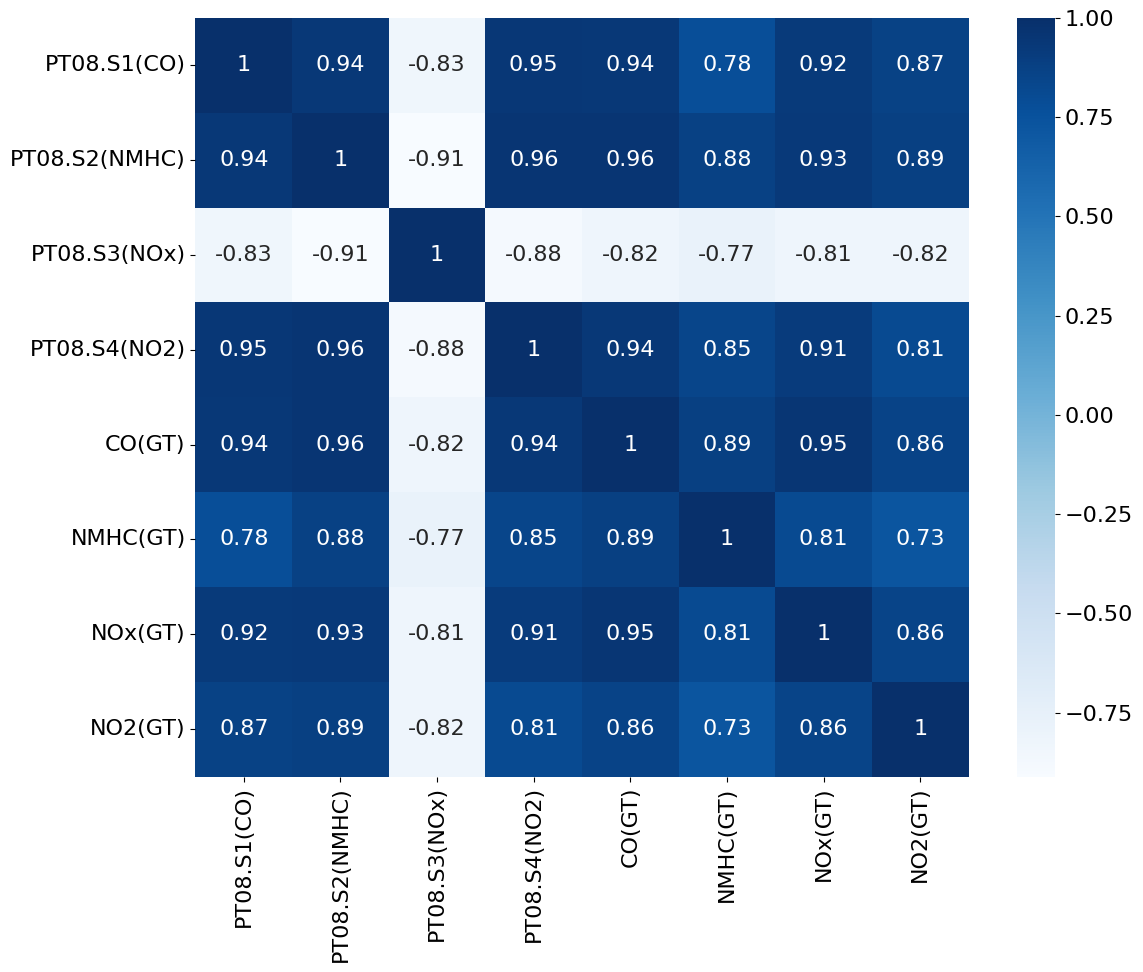

In [40]:
plt.figure(figsize=(12, 10))
# load the Auto dataset


# calculate the correlation matrix on the numeric columns
sns.heatmap(cross_detect_combined.corr(),annot=True,cmap='Blues')


plt.tight_layout()
#plt.show()


In [41]:
input_dim = 4
inter_dim = 4
latent_dim = 1
# Encoder
encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(inter_dim, activation='sigmoid')(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#Reparameterization Trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.)
    return z_mean + tf.exp(z_log_var / 2) * epsilon

# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = tfp.random.rayleigh(shape=tf.shape(z_mean), scale=1)
#     return z_mean + tf.exp(z_log_var / 2) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(inter_dim, activation='sigmoid')(latent_inputs)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# VAE model (combining encoder and decoder)
vae_outputs = decoder(encoder(encoder_inputs)[2])

vae_combined_outputs = tf.keras.layers.Concatenate(axis=1)([z_mean, z_log_var, z, vae_outputs])

vae_cross = Model(encoder_inputs, vae_combined_outputs, name='vae')

# Loss function (reconstruction loss + KL divergence)
def loss_fn(vae_in, vae_combined):
  reconstruction_loss = tf.keras.losses.mse(vae_in[:,:-1], vae_combined[:,-4:])
  z_log_var = vae_combined[:,1]
  z_mean = vae_combined[:,0]

  kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
  kl_loss = tf.reduce_mean(kl_loss)
  kl_loss *= -0.5

  calibration_loss = tf.keras.losses.mse(vae_in[:,-1], vae_combined[:,2])

  vae_loss = tf.reduce_mean(1*reconstruction_loss + 0*kl_loss + 1*calibration_loss)
  return vae_loss

# Training
vae_cross.compile(optimizer='adam' ,loss=loss_fn)

vae_cross.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4)              │             20 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │              5 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │              5 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 1), (None, 1), │             30 │ input_layer_2[0][0]    │
│                           │ (None, 1)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 4)              │             28 │ encoder[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 7)              │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_7[0][0],         │
│                           │                        │                │ lambda_1[0][0],        │
│                           │                        │                │ decoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 58 (232.00 B)

 Trainable params: 58 (232.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
vae_cross.fit(normalized_feature[:300], normalized_combined[:300], epochs=600, batch_size=16, shuffle=True)

Epoch 1/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5181
Epoch 2/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4519 
Epoch 3/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4152 
Epoch 4/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4383 
Epoch 5/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4251 
Epoch 6/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3770 
Epoch 7/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3227 
Epoch 8/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3599 
Epoch 9/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3108  
Epoch 10/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3253 
Epoch 11/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3038 
Epoch 12/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2573 
Epoch 13/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2972 
Epoch 14/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2660 
Epoch 15/600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

In [43]:
pred_data_vae_cross = vae_cross.predict(normalized_feature) #includes internal layer outputs
reconstructed_data_vae_cross = pred_data_vae_cross[:,2] #select temp values output and resize normalised output data
print(pred_data_vae_cross[1])
print(len(pred_data_vae_cross[:,2]))
print(len(normalized_combined.iloc[:,-1]))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[  0.22755958 -10.702821     0.22563086   0.3402605    0.35671008
   0.37775782   0.33403763]
827
827


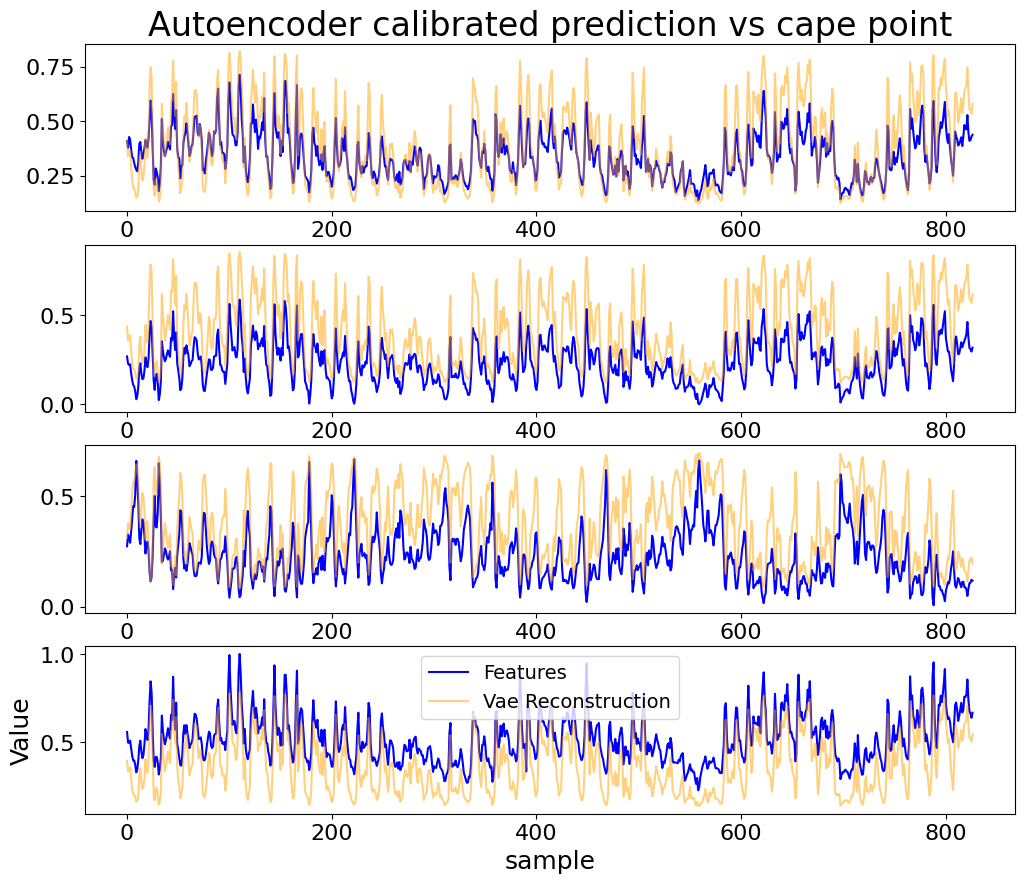

In [44]:
#%matplotlib widget

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
plt.rcParams.update({'font.size': 16})

plt.subplot(4,1,1)
plt.title('Autoencoder calibrated prediction vs cape point',fontsize=24)
plt.plot(normalized_feature[:,0].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae_cross[:,-4]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)


plt.subplot(4,1,2)
plt.plot(normalized_feature[:,1].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae_cross[:,-3]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)


plt.subplot(4,1,3)
plt.plot(normalized_feature[:,2].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae_cross[:,-2]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)


plt.subplot(4,1,4)
plt.plot(normalized_feature[:,3].reshape(-1), color = 'blue',label='Features')
plt.plot((pred_data_vae_cross[:,-1]).reshape(-1) , color = 'orange',label='Vae Reconstruction', alpha=0.5)

plt.xlabel('sample',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.legend(fontsize=14)

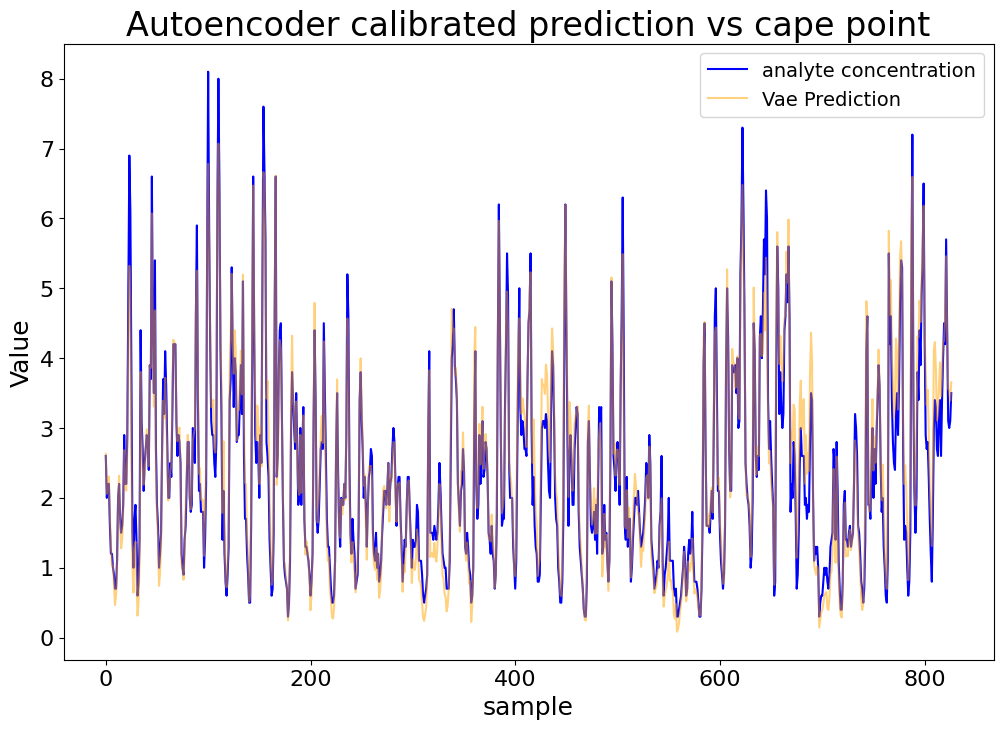

In [45]:
#%matplotlib widget

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.rcParams.update({'font.size': 16})

plt.plot((normalized_combined.iloc[:,-1].to_numpy()* scale_combined.iloc[-1]) + bias_combined.iloc[-1], color = 'blue',label='analyte concentration')
plt.plot((reconstructed_data_vae_cross* scale_combined.iloc[-1]) + bias_combined.iloc[-1] , color = 'orange',label='Vae Prediction', alpha=0.5)


plt.title('Autoencoder calibrated prediction vs cape point',fontsize=24)
plt.xlabel('sample',fontsize=18)
plt.ylabel('Value',fontsize=18)
plt.legend(fontsize=14)

In [46]:

test_set = NO2_cross_detect_combined.iloc[:,-1].to_numpy().reshape(-1)

print(np.mean(test_set))
# Use the predict method on the test data
predictions = (reconstructed_data_vae_cross* scale_combined[-1]) + bias_combined[-1]
#print(predictions)
# Calculate the absolute errors
errors = abs(test_set - predictions)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'PPM.')
import sklearn.metrics
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_set)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

r_squared = sklearn.metrics.r2_score(test_set,predictions)

print('r2 value: ' , r_squared)

def compute_probs(data, n=10):
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def kl_divergence(p, q):
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)


es3, hist_predict = compute_probs(predictions, 10)
ecp, hist_test_labels = compute_probs(test_set, 10)

#Padding hist for no 0 value bins
hist_predict = hist_predict + 1
hist_test_labels = hist_test_labels + 1

p, t = SciStat.pearsonr(test_set, predictions)
print('Pearson: ' + str(p))


print('KL divergence: ' + str(kl_divergence(hist_test_labels, hist_predict)) )
print('JS divergence: ' + str(js_divergence(hist_test_labels, hist_predict )) )


print(str(round(np.mean(errors), 2))+' & '+ str(round(accuracy, 2)) +' & '+str(round(r_squared,4))+' & '+ str(round(kl_divergence(hist_test_labels, hist_predict),5))+ ' & ' + str(round(js_divergence(hist_test_labels, hist_predict ),5))+"\n")

# 2.3535671100362756
# Mean Absolute Error: 0.26 PPM.
# Accuracy: 86.35 %.
# r2 value:  0.9376633549492681
# 0.9684132352378059
# KL divergence: 0.00923574224569915
# JS divergence: 0.002311441250999127

100.25997581620314
Mean Absolute Error: 97.86 PPM.
Accuracy: 2.22 %.
r2 value:  -9.590203285217285
Pearson: 0.8610750192985565
KL divergence: 0.025950751891477303
JS divergence: 0.006531693588598767
97.86 & 2.22 & -9.5902 & 0.02595 & 0.00653



<ipython-input-46-aa0975d25ca0>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = (reconstructed_data_vae_cross* scale_combined[-1]) + bias_combined[-1]


In [47]:
for i in range(0,4):

  test_set = NO2_cross_detect_combined.iloc[:,i].to_numpy().reshape(-1)

  #print(np.mean(test_set))
  # Use the predict method on the test data
  predictions = (pred_data_vae_cross[:,-4+i]* scale_combined[i]) + bias_combined[i]
  #print(predictions)
  # Calculate the absolute errors
  errors = abs(test_set - predictions)
  # Print out the mean absolute error (mae)
  #print('Mean Absolute Error:', round(np.mean(errors), 2), 'PPM.')
  import sklearn.metrics
  # Calculate mean absolute percentage error (MAPE)
  mape = 100 * (errors / test_set)
  # Calculate and display accuracy
  accuracy = 100 - np.mean(mape)
  #print('Accuracy:', round(accuracy, 2), '%.')

  r_squared = sklearn.metrics.r2_score(test_set,predictions)

  #print('r2 value: ' , r_squared)

  def compute_probs(data, n=10):
      h, e = np.histogram(data, n)
      p = h/data.shape[0]
      return e, p

  def kl_divergence(p, q):
      return np.sum(p*np.log(p/q))

  def js_divergence(p, q):
      m = (1./2.)*(p + q)
      return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)


  es3, hist_predict = compute_probs(predictions, 10)
  ecp, hist_test_labels = compute_probs(test_set, 10)

  #Padding hist for no 0 value bins
  hist_predict = hist_predict + 1
  hist_test_labels = hist_test_labels + 1

  p, t = SciStat.pearsonr(test_set, predictions)
  #print('Pearson: ' + str(p))


  #print('KL divergence: ' + str(kl_divergence(hist_test_labels, hist_predict)) )
  #print('JS divergence: ' + str(js_divergence(hist_test_labels, hist_predict ))+"\n" )

  print(str(round(np.mean(errors), 2))+' & '+ str(round(accuracy, 2)) +' & '+str(round(r_squared,4))+' & '+ str(round(kl_divergence(hist_test_labels, hist_predict),5))+ ' & ' + str(round(js_divergence(hist_test_labels, hist_predict ),5))+"\n")
  # 2.3535671100362756
  # Mean Absolute Error: 0.26 PPM.
  # Accuracy: 86.35 %.
  # r2 value:  0.9376633549492681
  # 0.9684132352378059
  # KL divergence: 0.00923574224569915
  # JS divergence: 0.002311441250999127

64.95 & 94.5 & 0.8917 & 0.01521 & 0.00382

40.79 & 95.28 & 0.9622 & 0.01259 & 0.00316

89.88 & 90.68 & 0.8293 & 0.0235 & 0.00587

52.4 & 96.65 & 0.9436 & 0.024 & 0.00603



<ipython-input-47-9ad1dac54994>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = (pred_data_vae_cross[:,-4+i]* scale_combined[i]) + bias_combined[i]
<ipython-input-47-9ad1dac54994>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = (pred_data_vae_cross[:,-4+i]* scale_combined[i]) + bias_combined[i]
<ipython-input-47-9ad1dac54994>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions = (pred_data_vae_

<ipython-input-48-29426a070bc3>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i, 0].hist((normalized_feature[:, i]* scale_combined[i]) + bias_combined[i], bins=bin_count)
<ipython-input-48-29426a070bc3>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i, 1].hist((pred_data_vae_cross[:, -num_features + i]* scale_combined[i]) + bias_combined[i], bins=bin_count)


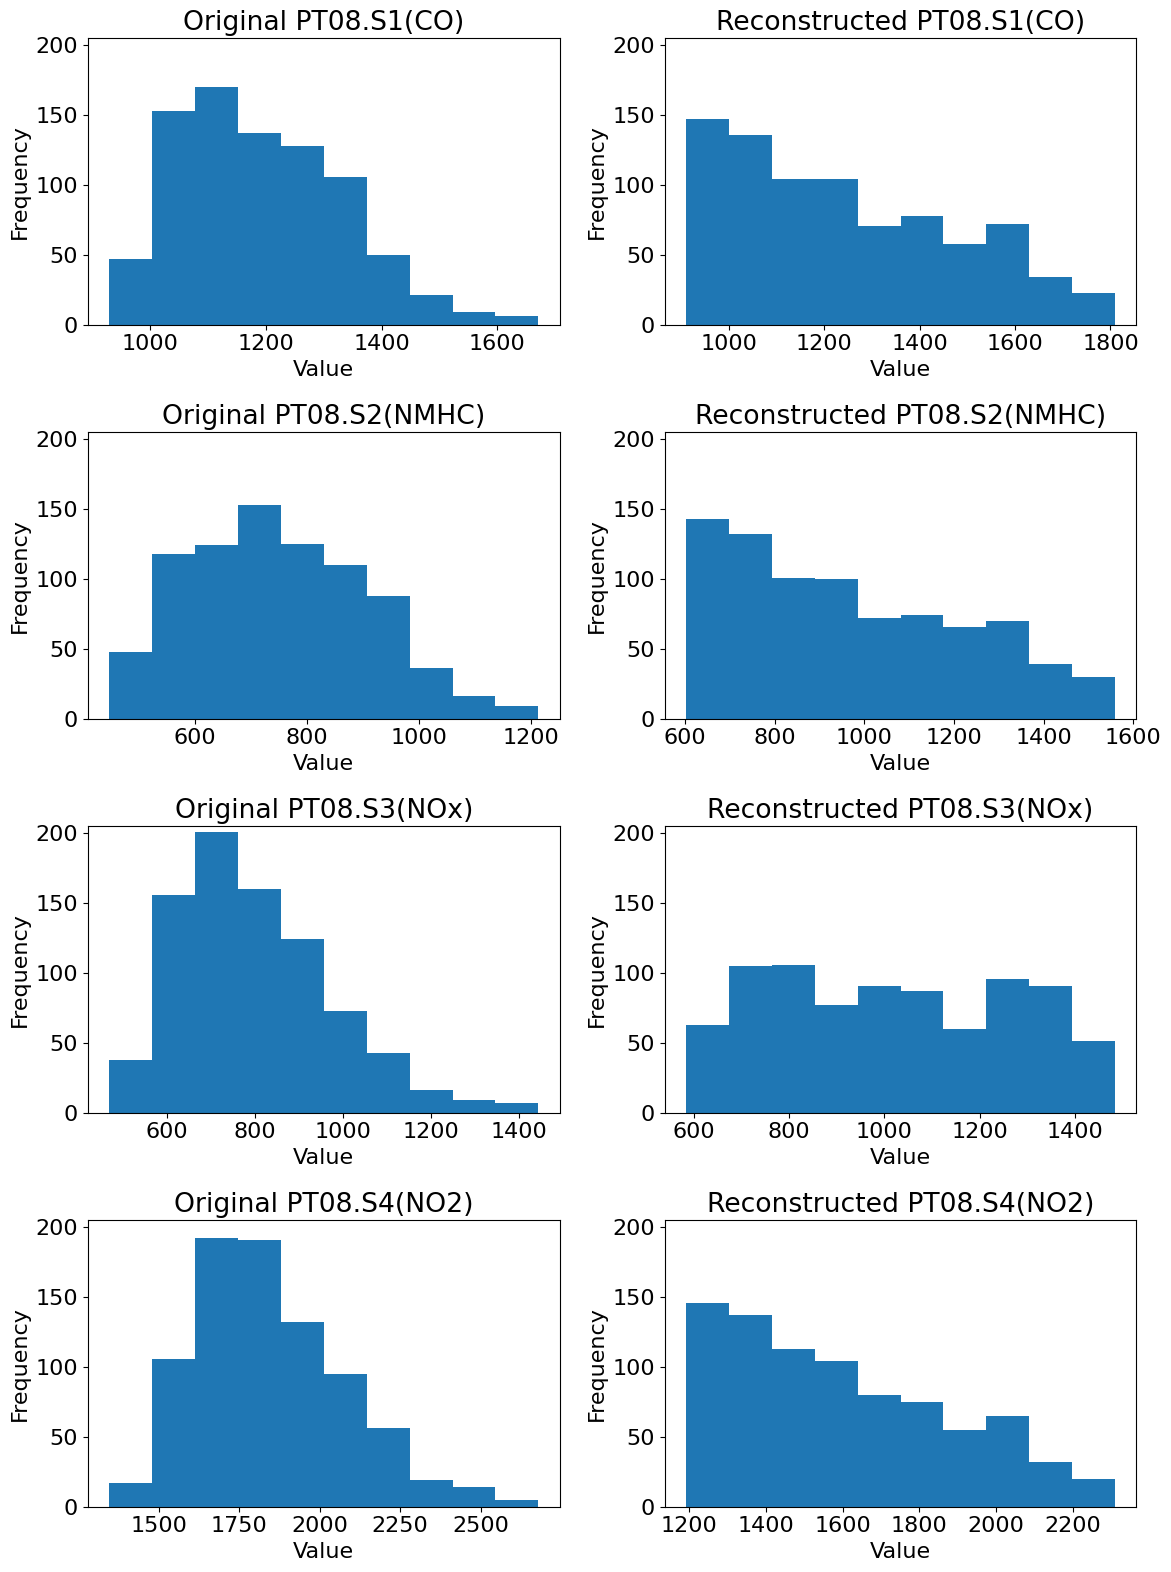

In [48]:

bin_count = 10
num_features = normalized_feature.shape[1]
fig, axes = plt.subplots(num_features, 2, figsize=(12, 4 * num_features))

feature_names = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']
y_range = 205
for i in range(num_features):
    # Original Feature Histogram
    axes[i, 0].hist((normalized_feature[:, i]* scale_combined[i]) + bias_combined[i], bins=bin_count)
    axes[i, 0].set_title(f'Original {feature_names[i]}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_ylim(0,y_range)
    # Reconstructed Feature Histogram
    axes[i, 1].hist((pred_data_vae_cross[:, -num_features + i]* scale_combined[i]) + bias_combined[i], bins=bin_count)
    axes[i, 1].set_title(f'Reconstructed {feature_names[i]}')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_ylim(0,y_range)

plt.tight_layout()
plt.show()

<ipython-input-49-cc3ad247b8a0>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0,0].hist((normalized_combined.iloc[:, -1]* scale_combined[-1]) + bias_combined[-1], bins=bin_count)
<ipython-input-49-cc3ad247b8a0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0,1].hist((pred_data_vae_cross[:, 2]* scale_combined[-1]) + bias_combined[-1], bins=bin_count)
<ipython-input-49-cc3ad247b8a0>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

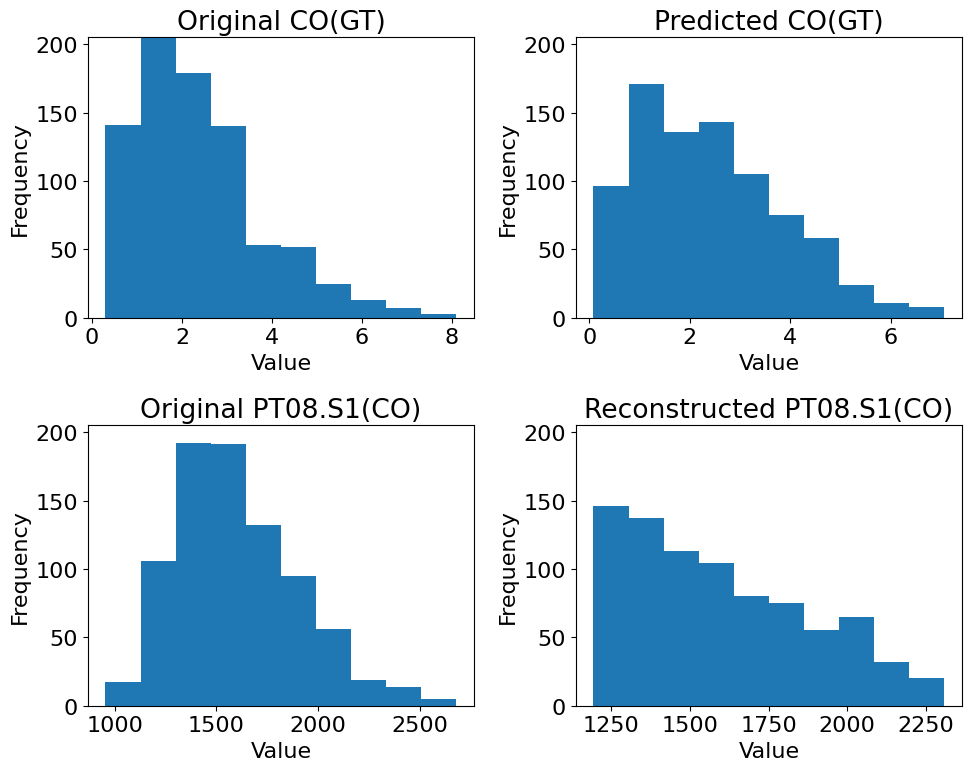

In [49]:

bin_count = 10
num_features = 2
fig, axes = plt.subplots(num_features, 2, figsize=(10, 4 * num_features))

feature_names = ['CO(GT)', 'PT08.S1(CO)']


# Original Feature Histogram
axes[0,0].hist((normalized_combined.iloc[:, -1]* scale_combined[-1]) + bias_combined[-1], bins=bin_count)
axes[0,0].set_title(f'Original {feature_names[0]}')
axes[0,0].set_xlabel('Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_ylim(0,205)
# Reconstructed Feature Histogram
axes[0,1].hist((pred_data_vae_cross[:, 2]* scale_combined[-1]) + bias_combined[-1], bins=bin_count)
axes[0,1].set_title(f'Predicted {feature_names[0]}')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_ylim(0,205)

axes[1,0].hist((normalized_combined.iloc[:, -2]* scale_combined[-2]) + bias_combined[-2], bins=bin_count)
axes[1,0].set_title(f'Original {feature_names[1]}')
axes[1,0].set_xlabel('Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_ylim(0,205)
# Reconstructed Feature Histogram
axes[1,1].hist((pred_data_vae_cross[:, -1]* scale_combined[-2]) + bias_combined[-2], bins=bin_count)
axes[1,1].set_title(f'Reconstructed {feature_names[1]}')
axes[1,1].set_xlabel('Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_ylim(0,205)


plt.tight_layout()
plt.show()
